# N-Body Gravitation Simulation

We implemented a gravitation simulation out of the given particle simulation. 

Copyright disclaimer: The following might contain some copied code from Willi Rath's project ;)  
Now that we have separated our problem, let's distribute the pieces.
We'll use [Dask.distributed](https://distributed.dask.org/) for distributed computing and [actors](https://distributed.dask.org/en/latest/actors.html).  More on actors [here](https://en.wikipedia.org/wiki/Actor_model).

## Create a Dask cluster

We'll have four workers with 4 threads each that will host different parts of our physical model.

In [1]:
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=4, memory_limit=1e9)
client

Client Scheduler: tcp://127.0.0.1:46069 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 4.00 GB


## Space, particles, and random numbers

The following is largely identical to what we did in [02_separation-Copy1.ipynb](02_separation-Copy1.ipynb).

In [2]:
%matplotlib inline
from dask.distributed import Client
import dask
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
import time
from IPython.display import HTML

The spatial domain doesn't call anything.  It's identical to the earlier implementation.

In [3]:
class PeriodicSpace:
    def __init__(self, length_x=10, length_y=20):
        self.length_y = length_y
        self.length_x = length_x
    
    def get_sizes(self):
        return self.length_x, self.length_y
        
    def normalize_positions(self, x, y):
        return np.mod(x, self.length_x), np.mod(y, self.length_y)

Each particle calls the spatial domain.  In distributed mode, we'll have to make sure that we get the `.result()` from the [`Future` objects](https://docs.python.org/3/library/concurrent.futures.html#future-objects) returned when calling methods on actors.

## Gravitation
The gravitation class/worker keeps track of the objects masses and provides a function that calculates the accelleration caused by gravitational forces between objects.  
We also wanted to optimize the calculation by using dasks delayed parallel execution and numpys vectorization.  
There is still quite a lot of waiting for data from other workers happening, because the objects positions need to be transferred between the workers. This slows everything down, but we didn't have the time to optimize that. You can clearly see the bursts happening in the dask-dashboard and then a lot time is spent waiting.

In [4]:
class Gravitation:
    def __init__(self, mass=None): #, client=None
        self.mass = mass
        self.gamma = 6.67384e-11
    def getMasses(self):
        return mass
    
    #returns accelleration of one body
    def computeGravitation(self, x, y, i):
        dX = np.subtract(x[i], x)
        dY = np.subtract(y[i], y)
        norm = np.sqrt(
            np.add(
                np.multiply(dX,dX),
                np.multiply(dY,dY)
            )
        )
        normPow2 = np.multiply(norm,norm)
        normPow2[i] = 1 # prevent division by 0
        fx = 0
        fy = 0
        m_div_norm = np.divide(self.mass, normPow2)

        fx = np.multiply(
                        -self.gamma*self.mass[i],
                        np.multiply(
                            dX,
                            m_div_norm
                        )
             )
        fy = np.multiply(
                        -self.gamma*self.mass[i],
                        np.multiply(
                            dY,
                            m_div_norm
                        )
             )
        sc_fx, sc_fy = np.sum(fx), np.sum(fy)
        return sc_fx / self.mass[i], sc_fy / self.mass[i]

    # returns the acceleration caused by gravitational forces
    def applyGravitationForces(self, x, y):
        lazy_results = []
        for i in range(len(x)):
            lazy_result = dask.delayed(self.computeGravitation)(x,y,i)
            lazy_results.append(lazy_result)

        results = dask.compute(*lazy_results)
        # [(fx,fy)] -> ([fx],[fy])
        fs = list(map(list, zip(*results) ) )
        return fs[0], fs[1]

## Particles
Particles has been modified to start with a uniformly distributed set of particles. The particles now have a velocity and acceleration on which their movement is based on. The latter is set by the new Gravitation worker.

In [5]:
class Particles:
    def __init__(
        self,
        space=PeriodicSpace(),
        gravitation=Gravitation(),
        x=None, y=None
    ):
        self.space = space
        self.gravitation = gravitation
        self.x, self.y = x, y
        self.vx = np.zeros(len(x))
        self.vy = np.zeros(len(y))
        self.ax = np.zeros(len(x))
        self.ay = np.zeros(len(y))
        self.steps_done = 0

    def move(self, dt):
        ax, ay = self.gravitation.applyGravitationForces(self.x, self.y).result()
        self.ax = ax
        self.ay = ay
        self.vx = np.add(self.vx, np.multiply(dt, self.ax))
        self.vy = np.add(self.vy, np.multiply(dt, self.ay))
        self.x = np.add(self.x, np.multiply(dt, self.vx))
        self.y = np.add(self.y, np.multiply(dt, self.vy))

        self.x, self.y = self.space.normalize_positions(self.x, self.y).result()
        self.steps_done += 1

    def center_of_mass(self):
        return self.x.mean(), self.y.mean()

    def moment_of_inertia(self):
        return self.x.var() + self.y.var()

    def diagnostics(self):
        com = self.center_of_mass()
        mi = self.moment_of_inertia()
        return pd.DataFrame(
            {
                "center_of_mass_x": com[0],
                "center_of_mass_y": com[1],
                "moment_of_inertia": mi
            },
            index=[self.steps_done, ],
        )

    def positions(self):
        return pd.DataFrame(
            {
                "x": self.x,
                "y": self.y
            }
        )
    

## Submit space, rng, gravitation and group of particles to the cluster

Some constants:

In [6]:
lightyear = 9.461e15
spacesize = lightyear
numParticles = 100
m = 1.98892e30 # solar mass
minMass = m
maxMass = 6*m
dt = 1e3 #1e3 looks good

Now submit all workers to the dask client:

In [7]:
space = client.submit(
        PeriodicSpace,
        length_x=spacesize, # 1 lightyear
        length_y=spacesize,
        actor=True,
        pure=False
    ).result()

In [8]:
rng = client.submit(
    np.random.RandomState, actor=True, pure=False
).result()

In [9]:
masses = rng.uniform(low=minMass, high=maxMass, size=numParticles).result()
gravitation = client.submit(
    Gravitation,
    mass=masses,
    actor=True, pure=False
)

In [10]:
length_x, length_y = space.get_sizes().result()

particles = client.submit(
    Particles, space=space, gravitation=gravitation,
    x=rng.uniform(low=0, high=length_x, size=numParticles).result(),#length_x / 2.0,
    y=rng.uniform(low=0, high=length_y, size=numParticles).result(),#length_y / 2.0,
    actor=True, pure=False
).result()

## Plot initial positions

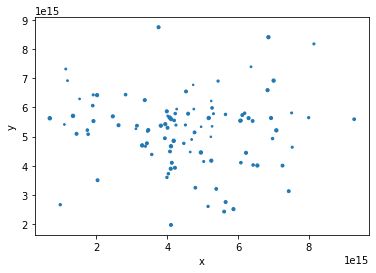

In [15]:
dot_sizes = 2 * (masses / m)
particles.positions().result().plot.scatter(x="x", y="y",s=dot_sizes);

## Create an animation (this might take a while...)
... but it's worth the wait :D

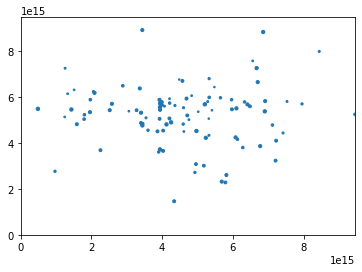

In [12]:
fig = plt.figure()
plt.xlim(0,spacesize)
plt.ylim(0,spacesize)
plt.autoscale(False)

df = particles.positions().result()

diags = particles.diagnostics().result()
def animate(i):
    df = particles.positions().result()
    plt.clf()
    plt.xlim(0,spacesize)
    plt.ylim(0,spacesize)
    
    plt.scatter(df.x,df.y,s=dot_sizes,alpha=1)
    global diags
    diags = diags.append(
        particles.diagnostics().result()
    )

    particles.move(dt).result()

diags = particles.diagnostics().result()
ani = animation.FuncAnimation(fig,animate,interval=33)
HTML(ani.to_jshtml())

## Plot diagnostic data

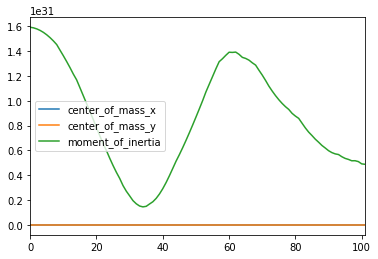

In [13]:
diags.plot();

The moment of inertia oscillates when the objects attract and then pass each other again and again.  
Thats a quite computational expensive way to approximate a damped oscillaition :D